In [124]:
import fasttext.util
#fasttext.util.download_model('de', if_exists='ignore')  
import nltk,pymysql
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from germalemma import GermaLemma
from HanTa import HanoverTagger as ht
from nltk.util import ngrams
import numpy as np
import seaborn as sns
from collections import  Counter
from hdbscan import HDBSCAN
from gensim.models.wrappers import FastText
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from nltk.stem.snowball import GermanStemmer
from nltk.tokenize import RegexpTokenizer,TreebankWordTokenizer

from nltk.stem.cistem import Cistem
stem= GermanStemmer()


In [10]:
ft = fasttext.load_model('cc.de.300.bin')

model = FastText.load_fasttext_format('cc.de.300.bin')
model.similar_by_vector(ft.get_sentence_vector('hallo')) 

[('hallo', 1.0),
 ('Hallo', 0.828432559967041),
 ('hallo.', 0.7311663031578064),
 ('Hey', 0.7070685029029846),
 ('huhu', 0.7036963701248169),
 ('hallihallo', 0.6963691711425781),
 ('hallöchen', 0.6931374073028564),
 ('moin', 0.6886731386184692),
 ('halloich', 0.6857973337173462),
 ('hey', 0.6842083930969238)]

In [61]:
df =pd.read_csv('bild_articles.csv',index_col=0)[['headline','text']].head(5000)
df

,headline,text
article_uid,,
8c7b60bbbbab27058f93ba3114462b0b9b82f79c3cf3e95e52cf8013742b1f89,Blitz-Comeback von Reus,Wenn du bei deinem Comeback nach 223 Tagen nur...
66ef992ac10f512ce621314bcffcbc542549ba1f52c8b11696e33d8730998aba,Türkgücü-Bosse erklärenihre Pokal-Klage,Es war DER Aufreger der 1. DFB-Pokal-Runde. T...
bafa8f876a14f50c6010a8ea2ff4de2265e508af13c5007ddb363a4c4b155f4e,Islamist stachschon einmal zu!,Stolberg/Aachen – Der Messerangriff von Stolbe...
e353f0b8121a6f0addf3ea3ca5eead419c904d283284fcffcf913ff6f2f39b1c,Die neuen Hierarchien der 18 Klubs,Die neue Serie „Die neuen Hierarchien der 18 K...
f168dc072b52b38187937175639830ef066209100ffaeea780cb03cd943706d3,Gisdol schon vorm Start unter Druck!,Das hatte sich Markus Gisdol (50) bei seiner V...
...,...,...
71e918129176bac4409d265bc96dc2568dd62f02967557700fcfbdb0fee858c2,Sabrina macht die beste Bratwurst in Deutschland,Tränen der Freude für die Bratwurst des Jahres...
901db194e5c5f5ff64720593fce085ec8352ce8d2890c93a99cc47e390963d30,Jetzt kommt Scholl - 3x LIVE beim Finale,Jetzt kommt Scholl – zum großen Bayern-Triple-...
6fd2455826e44374a2c0f9ee1d622e447439dde918e09d78d197348b76f5a751,Kein Karneval wegen Corona,Hannover – Das Prinzenpaar der letzten Session...


In [127]:
tokenizer = TreebankWordTokenizer()#RegexpTokenizer(r'\w+')

def preprocess_news(df):
    corpus=[]
    tmp = stopwords.words('german')
    tmp.extend(['eins','zwei','drei','fünf','vier','sechs','sieben','neun','zehn','BILD','beim','wegen','darum'])
    stop=set(tmp)
    for news in df['text']:
        words=[w for w in tokenizer.tokenize(news) if (w.lower() not in stop)]
        words=[stem.stem(w) for w in words]
        
        corpus.append(words)
    return corpus


In [128]:


dataset =[' '.join(x) for x in preprocess_news(df) ]

tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(dataset)
tf = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
tf = tf.sort_values('TF-IDF', ascending=False)
print (tf.head(35))

                   TF-IDF
watzk            0.254842
reus             0.238207
hazard           0.192298
bvb              0.185240
teeni            0.176466
bellingham       0.172945
sancho           0.164798
freistoss        0.138229
steigt           0.110657
dortmund         0.108617
trifft           0.108038
hsv              0.104681
paus             0.102639
223              0.100780
vorentscheidung  0.100780
leuchten         0.100780
lucian           0.100780
rekordkulisse    0.100780
thorgan          0.100780
staatskanzleien  0.096149
273              0.096149
tagesordnung     0.096149
gehammert        0.096149
duschen          0.096149
losverfahr       0.096149
verantwortbar    0.096149
hacken           0.092864
hinkrieg         0.092864
pflichtspieltor  0.092864
probebetrieb     0.090315
sehnenriss       0.090315
365              0.088233
ligastart        0.088233
zaubert          0.088233
ablag            0.088233


0.18462542201578125

In [ ]:
vectors = []
for para in preprocess_news(df):
    try:
        ve = np.array([tf.loc[word.lower()].values[0]*ft.get_word_vector(word) for word in para])
    except KeyError as err:
        #print(err)
        ve = np.array([ft.get_word_vector(word) for word in para])
    vectors.append(np.sum(ve,axis=0))


/Users/ttkaczyk/opt/anaconda3/envs/py37/lib/python3.7/site-packages/hdbscan/hdbscan_.py:219: UserWarning:

Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 



<AxesSubplot:ylabel='$\\lambda$ value'>

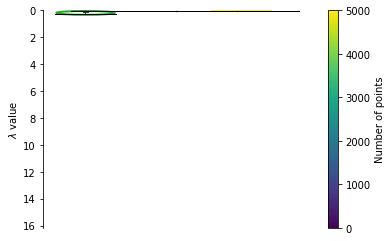

In [130]:
from sklearn.preprocessing import normalize


clusterer = HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=True, leaf_size=40 ,   cluster_selection_epsilon=0.001,
    metric='euclidean', min_cluster_size=5, min_samples=None)
clusterer.fit(vectors)
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())


<AxesSubplot:xlabel='x', ylabel='y'>

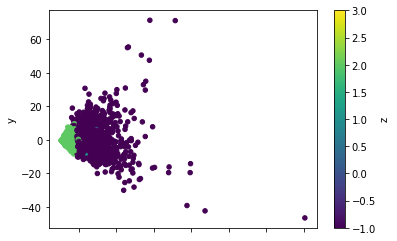

In [131]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
p =pd.DataFrame(pca.fit_transform(vectors),columns=["x",'y'])
p['z']=clusterer.labels_
p.plot(x="x",y="y",c='z',colormap='viridis',kind="scatter")


In [132]:
from sklearn.manifold import TSNE
p = TSNE(n_components=3,random_state=0).fit_transform(vectors)
p = pd.DataFrame(p,columns=["x",'y','z'])
p['label']=clusterer.labels_
p['headline'] = df.head(5000)['headline'].values


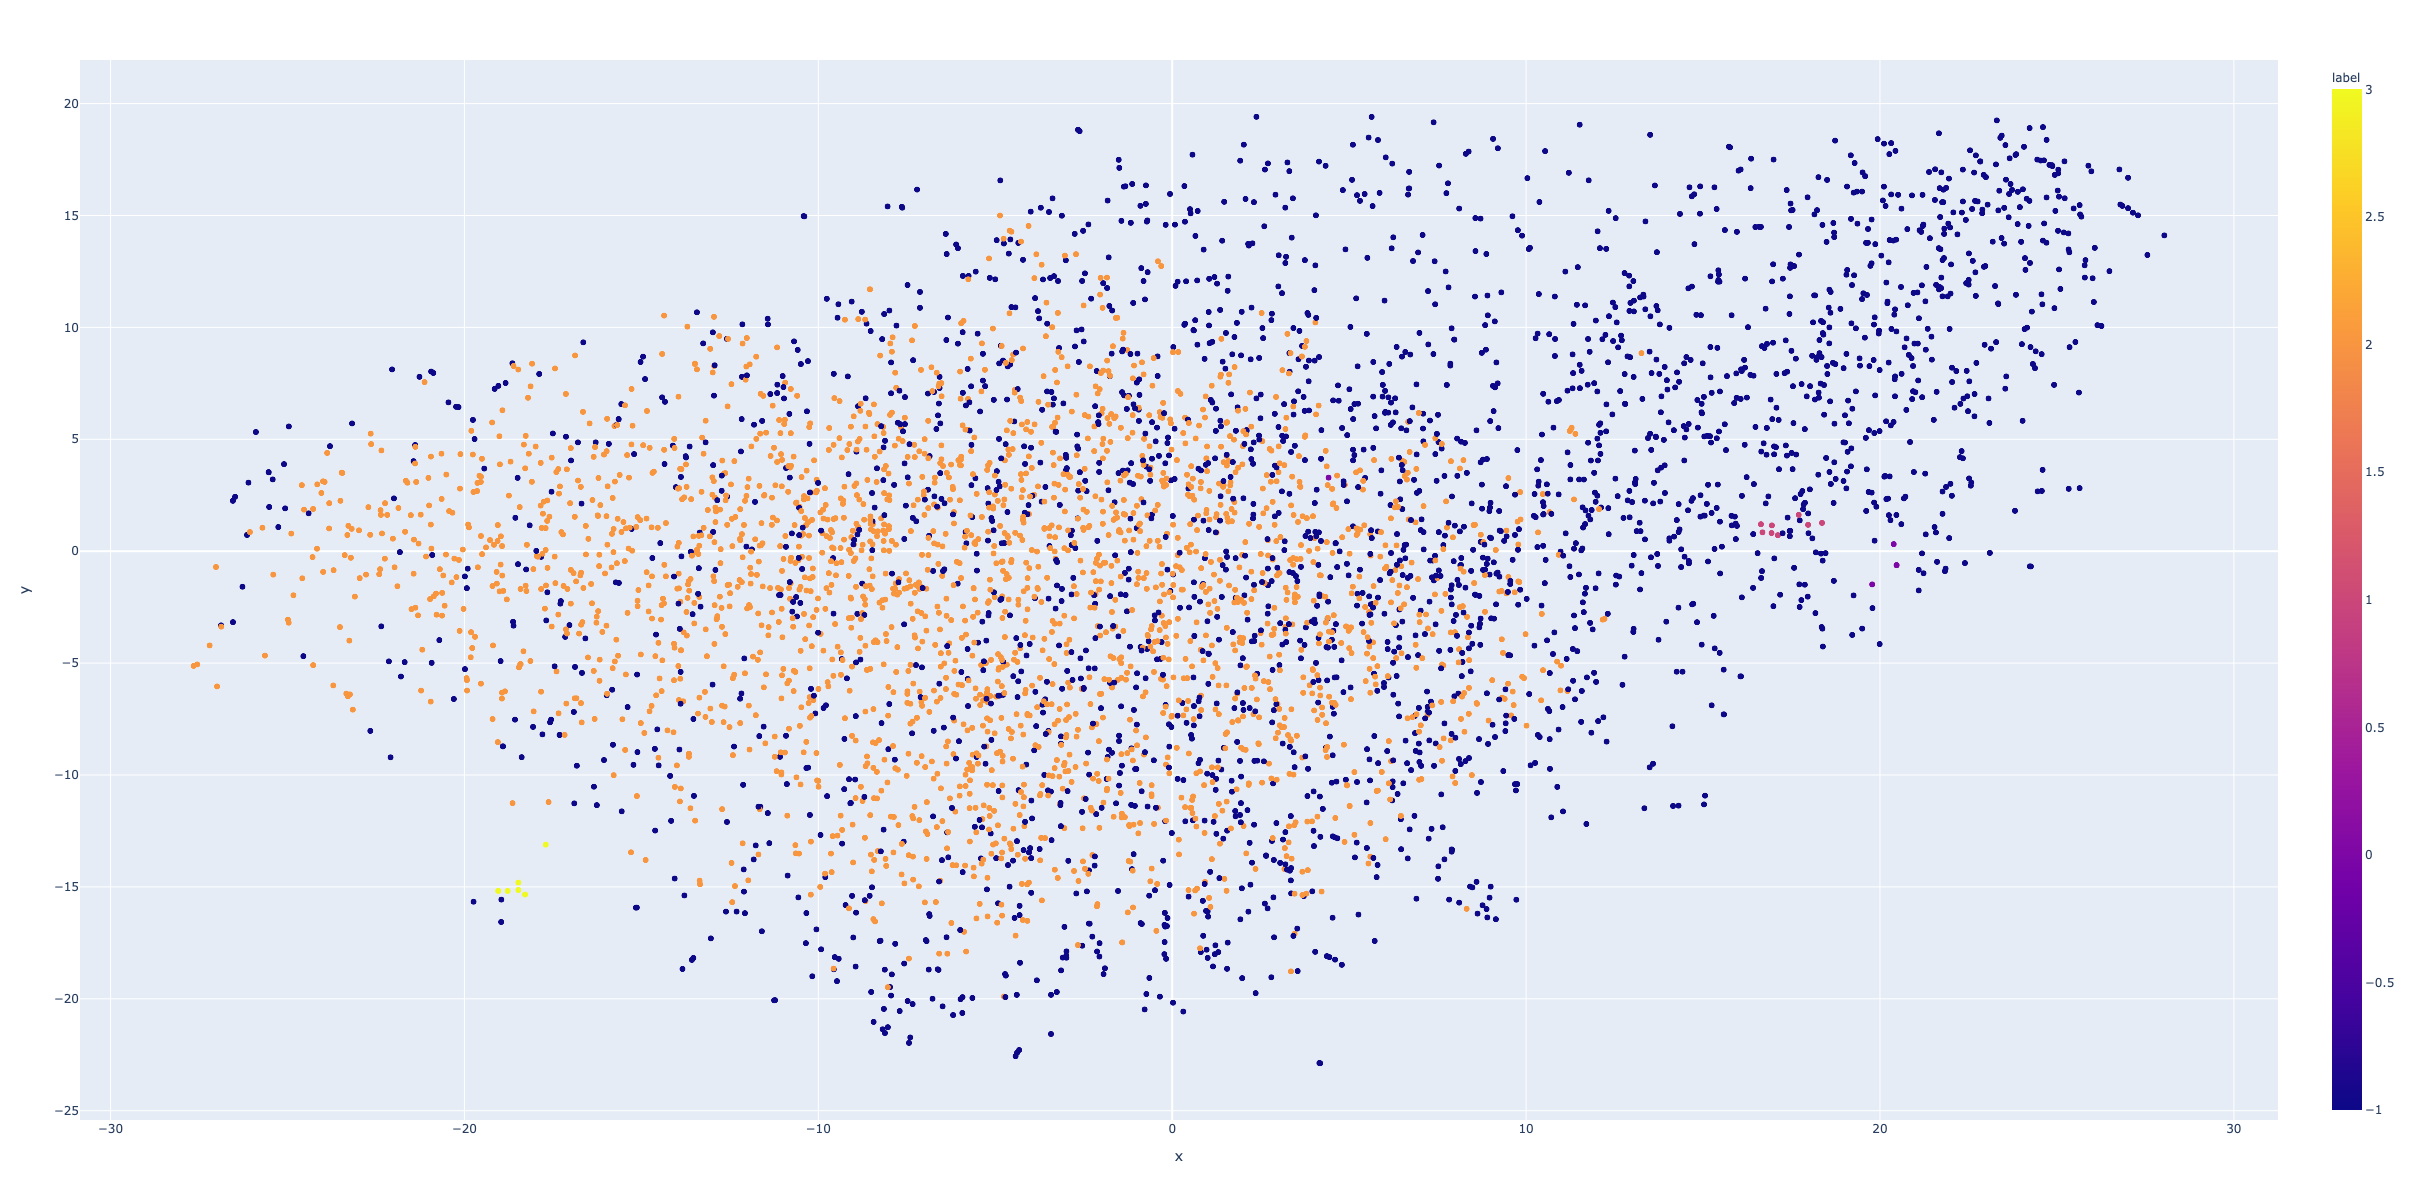

In [133]:
import plotly.offline as py
import plotly.express as px

fig = px.scatter(p, x="x", y="y", hover_name="headline", color = "label", size_max=60)
fig.update_layout(
     height=1200)




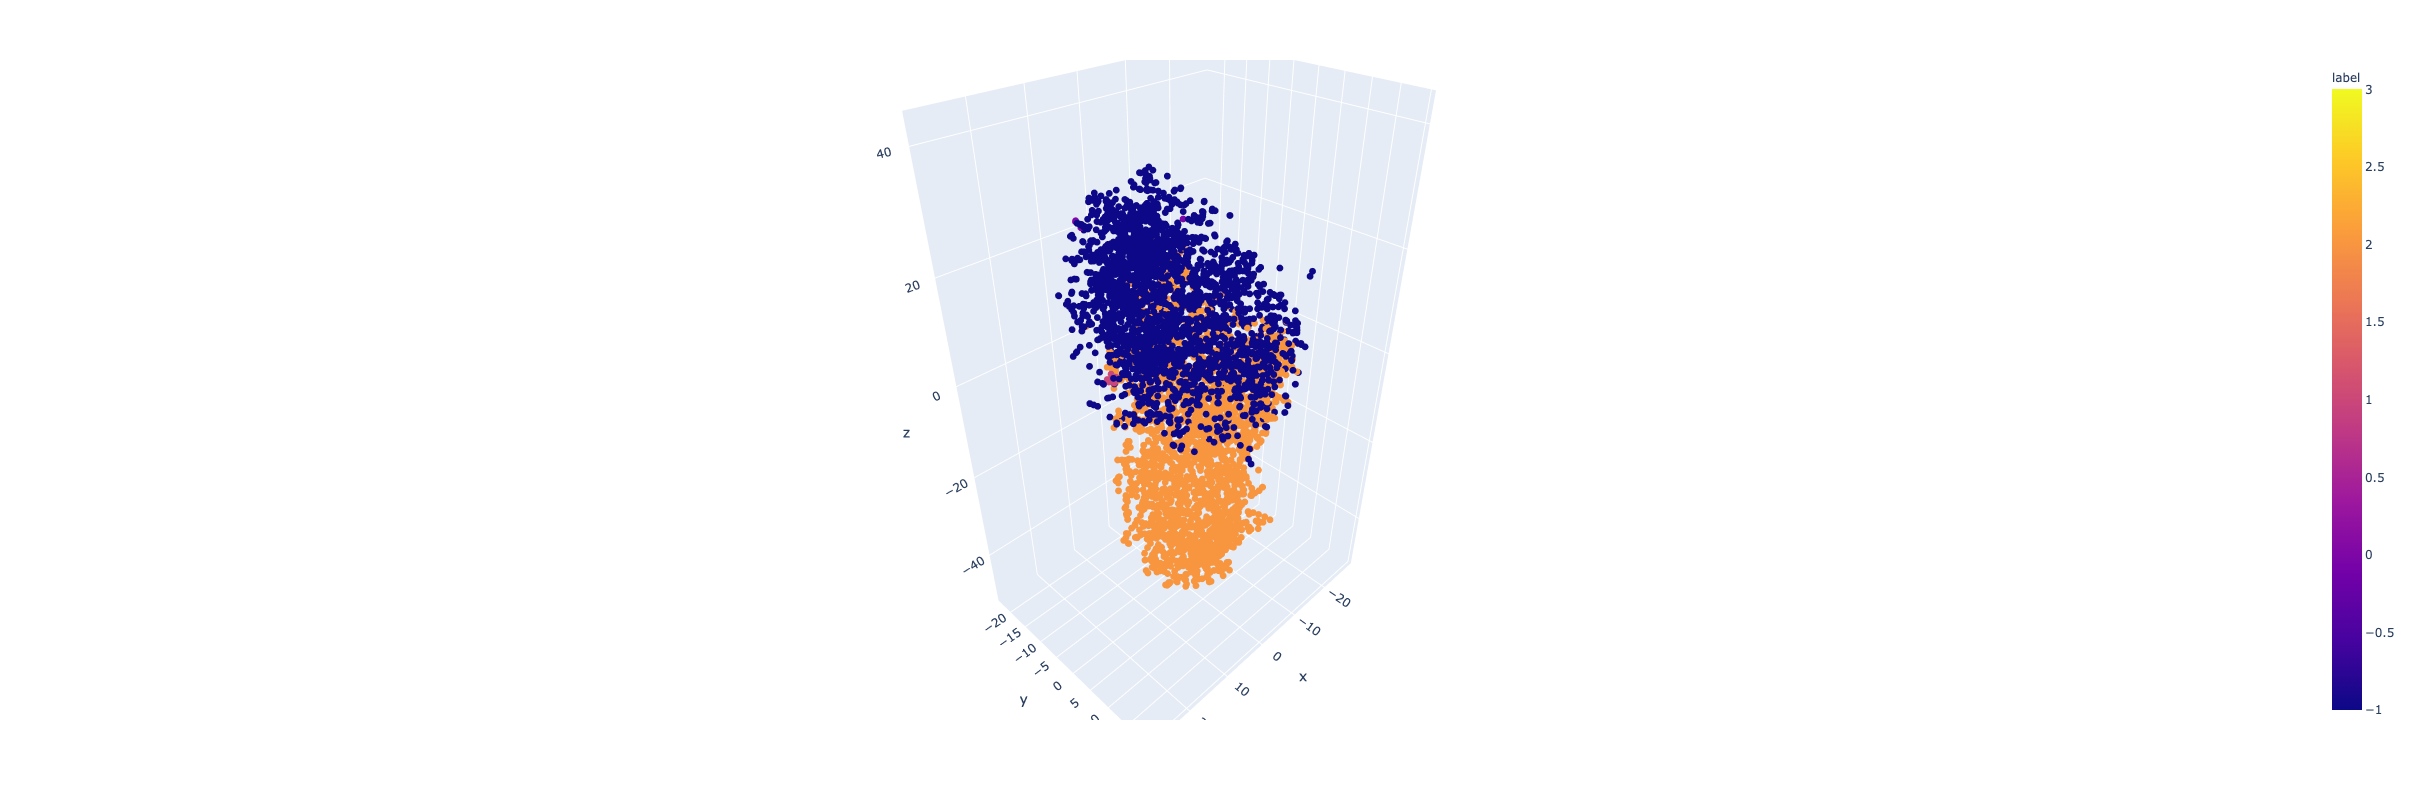

In [134]:

fig = px.scatter_3d(
    p, x='x', y='y', z='z',hover_name="headline",
    color='label', labels={'color': 'species'}
)
fig.update_traces(marker_size=4)
fig.update_layout(
     height=800)
fig.show()


In [97]:
p

,x,y,z,label,headline
0,0.757031,8.786022,29.867451,-1,Blitz-Comeback von Reus
1,-16.520517,1.205459,24.907187,53,Türkgücü-Bosse erklärenihre Pokal-Klage
2,12.657830,14.913321,-6.601226,-1,Islamist stachschon einmal zu!
3,-12.803359,17.167189,1.186025,10,Die neuen Hierarchien der 18 Klubs
4,-8.353460,3.853318,9.948076,-1,Gisdol schon vorm Start unter Druck!
...,...,...,...,...,...
4995,15.687160,-16.528374,-6.307943,-1,Sabrina macht die beste Bratwurst in Deutschland
4996,-25.286497,0.471921,6.621976,66,Jetzt kommt Scholl - 3x LIVE beim Finale
4997,20.191895,0.145609,-4.905133,68,Kein Karneval wegen Corona
4998,7.714036,9.424835,8.243121,-1,"Warum Enten füttern, wenn man sie nicht futter..."
